In [50]:
import torch
import torchvision.transforms.v2 as v2

In [4]:
from datasets import load_dataset

ds = load_dataset("zh-plus/tiny-imagenet")

Generating valid split: 100%|██████████| 10000/10000 [00:00<00:00, 605142.62 examples/s]


In [51]:
class MyDataset():
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, idx):
        x = self.dataset[idx]['image']
        y = self.dataset[idx]['label']
        if self.transform:
            x = self.transform(x)
        
        return x, y

    def __len__(self):
        return len(self.dataset)

In [62]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

data_transforms = {
    'train': v2.Compose([
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ]),
    'val': v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ]),
    'test': v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ])
}

In [63]:
from torch.utils.data import DataLoader

In [66]:
train_dataset = MyDataset(ds['train'], transform=data_transforms['train'])

train_subset, val_subset = torch.utils.data.random_split(train_dataset, [90000, 10000], generator=torch.Generator().manual_seed(1))

test_dataset = MyDataset(ds['valid'], transform=data_transforms['test'])

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


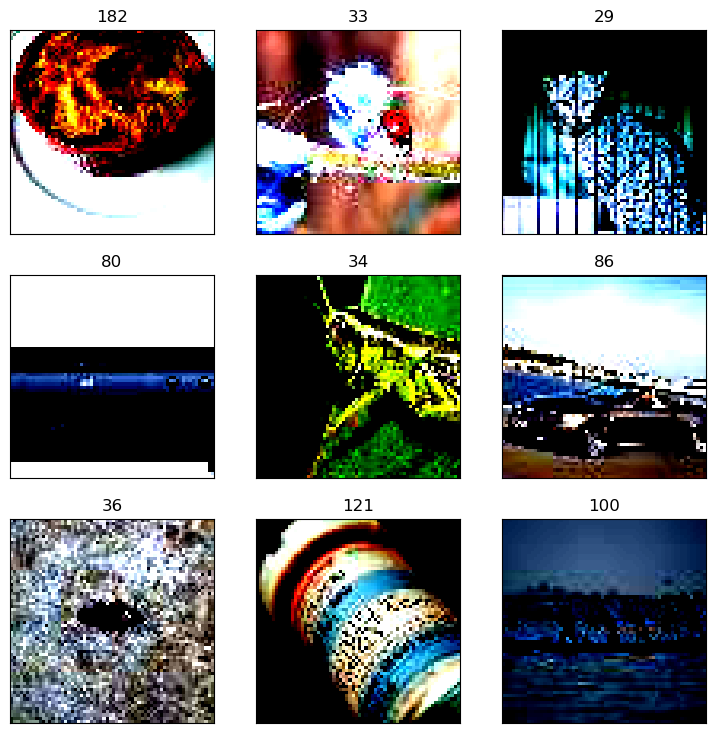

In [358]:
# visualize portion of training data:
import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(9,9))

for i in range(9):
    idx = random.randint(0, len(train_dataset))
    img, label = train_dataset[idx]
    ax = plt.subplot(3, 3, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(label)

    ax.imshow(torch.clamp(img.view(3, 64, 64).permute(1, 2, 0), 0, 1))

In [67]:
BATCH_SIZE = 64
train_data_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [348]:
# Embedding class

class ImageEmbedding(nn.Module):
    """
        take square image of CxNxN pixels and create linear map of PxP patches to embedding dimension D
        Input: (B, C, N, N)
        Output: (B, C * P**2, D)
    """
    def __init__(self, img_size, patch_size, emb_size, num_channels, layer_norm_eps=1e-12, dropout=0.1):
        super().__init__()
        
        if img_size % patch_size != 0:
            raise Exception("image size must be divisible by patch size")
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_channels = num_channels

        max_seq_len = int(num_channels * patch_size**2)

        self.patch_embeddings = nn.Linear(max_seq_len, emb_size, bias=False)
        self.prepend_embedding = nn.Parameter(torch.randn(1, emb_size))
        self.positional_embeddings = nn.Linear(max_seq_len, emb_size, bias=False)

        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("position_ids", torch.arange(max_seq_len).expand((1, -1)).float())

    def forward(self, img):
        # patch input image (C, N, N) --> ((N/P)**2, P**2 * C)
        p = self.patch_size
        img = img.unfold(2, p, p).unfold(3, p, p).transpose(1, 3).reshape(-1, int(self.img_size/self.patch_size)**2, self.patch_size**2 * self.num_channels)
        emb = self.patch_embeddings(img)
        
        # prepend learnable embedding
        batch_size = img.shape[0]  
        prepend_embedding = self.prepend_embedding.expand(batch_size, -1)
        emb = torch.cat((prepend_embedding.unsqueeze(1), emb), dim=1)

        # add positional embedding
        emb = emb + self.positional_embeddings(self.position_ids)

        # add normalization and dropout
        emb = self.ln(emb)
        emb = self.dropout(emb)
        
        return emb

In [353]:
# Implement transformer encoder

class AttentionBlock(nn.Module):
    def __init__(self, emb_size, head_size):
        super().__init__()
        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)
    
    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        out = F.softmax(q @ k.transpose(1, 2) * C**-0.5) @ v
        return out


In [354]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, emb_size, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(AttentionBlock(emb_size, head_size) for _ in range(n_heads))
        self.proj = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        return out

In [355]:
class FeedForward(nn.Module):
    def __init__(self, emb_size, scale):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(emb_size, scale * emb_size),
            nn.GELU(),
            nn.Linear(scale * emb_size, emb_size)
        )
    
    def forward(self, x):
        out = self.layers(x)
        return out

In [356]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_size, n_heads, scale=4, layer_norm_eps=1e-12):
        super().__init__()
        head_size = emb_size // n_heads

        self.att = MultiHeadedAttention(emb_size, n_heads, head_size)
        self.ff = FeedForward(emb_size, scale)
        self.ln1 = nn.LayerNorm(emb_size, layer_norm_eps)
        self.ln2 = nn.LayerNorm(emb_size, layer_norm_eps)
    
    def forward(self, x):
        out = self.att(self.ln1(x)) + x
        out = self.ff(self.ln2(out)) + out
        return out

In [359]:
class CustomViT(nn.Module):
    def __init__(self, vocab_size, emb_size, img_size, patch_size, num_channels, n_heads, n_layers, scale):
        self.emb = ImageEmbedding(img_size, patch_size, emb_size, num_channels)

        modules = []
        for _ in n_layers:
            modules.append(TransformerBlock(emb_size, n_heads, scale))
        self.blocks = nn.Sequential(*modules)
        self.mlp_head = nn.Linear(emb_size, vocab_size)
    
    def forward(self, x, target=None):
        B, C, N, _ = x.shape

        emb = self.emb(x) # B, T, D
        out = self.blocks(emb) # B, T, D
        all_logits = self.mlp_head(out) # B, T, vocab_size

        # using class token for predictions
        logits = all_logits[:, 0, :]
    
        if not target:
            loss = None
        else:
            loss = F.cross_entropy(logits, target)
        
        return logits, loss

In [ ]:
# training loop

